In [1]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('qt5agg')
import params
from utils import *
from matplotlib.gridspec import GridSpec
import math
from scipy.io import loadmat

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy as sc
from sklearn.decomposition import SparsePCA

## Cell 1: Load triggers and spikes + select chirp type !!!!

In [2]:
exp = params.exp

#choose the chirp recording
recording_names = params.recording_names

print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(recording_names)], sep="\n")
rec = recording_names[int(input("\nSelect chirp recording : "))]
print(rec)
#If False: new chirp at 50Hz, if True: old 2p room chirp   !!!!!!!!!
old=False

#load triggers
trig_data = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,rec))))
stim_onsets = trig_data['indices']/params.fs   

#load spikes
output_directory=params.output_directory

spike_trains=load_obj(os.path.join(output_directory, r'{}_fullexp_neurons_data.pkl'.format(exp)))

cells=list(spike_trains.keys())
spike_times=[]
for cell in cells:
    spike_times.append(spike_trains[cell][rec])

0 : 00_Checkerboard_30ND50%_20pix30checks_30Hz
1 : 01_Checkerboard_30ND50%_16pix40checks_30Hz
2 : 02_DG_30ND50%_2sT_50Hz
3 : 03_Chirp_20reps_30ND50%_50Hz
4 : 04_Flicker_BeforeDrugs_30ND50%_1Hz
5 : 05_VDH_Synchro+MultiSpots(bright)_N8_Z(-35)_30ND50%_40Hz
6 : 06_VDH_Synchro_N10_Z(-35)_30ND50%_40Hz
7 : 07_Flicker_LAP4+ACET_t+10_30ND50%_1Hz
8 : 08_HoloStim1_LAP4+ACET_N8_Z(-35)
9 : 09_HoloStim1_LAP4+ACET_N15_Z(-30)
10 : 10_OptoStim1_LAP4+ACET_15ND50%_1Hz
11 : 11_OptoStim1_LAP4+ACET_5ND50%_1Hz
12 : 12_HoloStim2_GRF_t30_N15_Z(-30)
13 : 13_OptoStim2_GRF_t35_15ND50%_1Hz
14 : 14_OptoStim2_GRF_t40_5ND50%_1Hz
15 : 15_HoloStim3_SR95531_t30_N15_Z(-30)
16 : 16_OptoStim3_SR95531_t35_15ND50%_1Hz
17 : 17_OptoStim3_SR95531_t40_5ND50%_1Hz
18 : 18_HoloStim3_18BG_t5_N15_Z(-30)
19 : 19_OptoStim3_18BG_t10_15ND50%_1Hz
20 : 20_OptoStim3_18BG_t15_5ND50%_1Hz
21 : 21_HoloStim3_18BG_t20_N15_Z(-30)

Select chirp recording : 3
03_Chirp_20reps_30ND50%_50Hz


## Cell 2: Chirp rasters

In [3]:
if old: 
    nb_repetitions = 30
    n_bins=625
    rep_lenght=25
else: 
    nb_repetitions = 20 
    n_bins=800             #CHANGE HERE THE NUMBER OF BINS IF NECESSARY
    rep_lenght=32
time_bin= rep_lenght/n_bins #in seconds

cell_data={}
for idx,cell_nb in tqdm(enumerate(cells[:])):
    if not cell_nb in cell_data.keys(): cell_data[cell_nb]={}
    
    #Get spike_times
    euler_sptimes = spike_times[idx]

    aligned_triggers = stim_onsets  #(in seconds)
    
    # Flashes: Get the repeated sequence times for the specified position
    repeated_sequences_times = []
    for i in range(0,nb_repetitions):
        if old: times = aligned_triggers[i*999:999*(i+1)]
        else: times = aligned_triggers[i*1600+151:151+1600*(i+1)]
        repeated_sequences_times += [[times[0], times[-1]]]

    # Build the spike trains corresponding to stimulus repetitions
    spike_trains = []
    for i in range(len(repeated_sequences_times)):
        spike_train = restrict_array(euler_sptimes, repeated_sequences_times[i][0], repeated_sequences_times[i][1])
        spike_trains += [spike_train]

    # Align the spike trains
    for i in range(len(spike_trains)):
        spike_trains[i] = spike_trains[i] - repeated_sequences_times[i][0]
        
    # Compute psth
    binned_spikes = np.empty((nb_repetitions,n_bins))   #40 ms time bin
    for i in range(nb_repetitions):
       
       binned_spikes[i,:] = np.histogram(spike_trains[i], bins=n_bins, range=(0,rep_lenght))[0]
    binned_spikes = np.sum(binned_spikes, axis=0)
    
    # Transform spike count in firing rate
    binned_spikes = binned_spikes / time_bin

    cell_data[cell_nb]["spike_times"] = spike_times
    cell_data[cell_nb]["repeated_sequences_times"] = repeated_sequences_times
    cell_data[cell_nb]["spike_trains"] = spike_trains
    cell_data[cell_nb]["psth"] = binned_spikes    

0it [00:00, ?it/s]

## Cell 3: Plot Chirp rasters

With addaed spatial STA in order to be able to use this plot alone to do cell selection for clustering

#### <center><i>REQUIRES CELL 2 RUN AND CHECKERBOARD ANALYSIS</center>

In [5]:
# Plot the rasters

fig_directory = os.path.normpath(os.path.join(output_directory,r'Chirp_rasters+STA'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

sta_results=np.load(os.path.join(output_directory,'sta_data_3D_fitted.pkl'),allow_pickle=True)    

if old:
    vec_path = os.path.join('./types_matching', r"EulerStim180530.vec")
    euler_vec = -np.genfromtxt(vec_path)
    rep_lenght = 25
    n_bins = 625
    n_reps = 30
    
else:    
    vec_path = os.path.join('./types_matching', r"Euler_50Hz_20reps_1024x768pix.vec")
    euler_vec = np.genfromtxt(vec_path) 
    rep_lenght = 32
    n_bins = 800
    n_reps = 20

time_bin = rep_lenght/n_bins #in seconds
for cell_nb in tqdm(cells[:]):

    fig = plt.figure(figsize=(19,6))
    gs = GridSpec(8, 19, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.4, hspace=0, figure=fig)
#     fig=plt.figure(figsize=(16,6))

    #plot Chirp stimulus
    ax=fig.add_subplot(gs[0:2, :-3])
    if old:ax.plot(np.linspace(0,rep_lenght,999),euler_vec[1:1000,1], color='k')
    else: ax.plot(np.linspace(0,rep_lenght,1600),euler_vec[151:1751,1], color='k')
    ax.set_ylabel('Chirp Stimulus')
    ax.set_yticks([])
    ax.set_title('Cluster {}'.format(cell_nb))
    ax.set_xlim([0,rep_lenght])

    #plot chirp raster
    ax=fig.add_subplot(gs[2:5, :-3])
    ax.eventplot(cell_data[cell_nb]["spike_trains"],color='k',lw=1,linelengths=1)
    ax.set_ylabel('#Trial')
    ax.set_xlim([0,rep_lenght])
    
    #plot chirp psth
    ax=fig.add_subplot(gs[5:, :-3])
    ax.step(np.linspace(0,rep_lenght,n_bins),cell_data[cell_nb]["psth"])
    ax.set_ylabel('Firing rate Hz \n ({} ms time bin)'.format(int(time_bin*1000)))
    ax.set_xlabel("Time (s)")
    ax.set_xlim([0,rep_lenght])
    
    #plot spatial STA
    ax = fig.add_subplot(gs[0:3, -3:])
    ax.set_title("STA",fontsize=12 )
    spatial = sta_results[cell_nb]['center_analyse']['Spatial']
    spatial = spatial**2*np.sign(spatial)
    cmap='RdBu_r'
    image = ax.imshow(spatial, cmap=cmap,interpolation='gaussian')
    abs_max = 0.5*max(np.max(spatial), abs(np.min(spatial)))
    image.set_clim(-abs_max,abs_max)
    ax.set_xticks([])
    ax.set_yticks([])
    
    fsave = os.path.join(fig_directory, '{}_Chirp_raster+STA'.format(cell_nb)) 
    fig.savefig(fsave+'.png',format='png',dpi=90)
    plt.close(fig)
    
print('Done!')    


  0%|          | 0/276 [00:00<?, ?it/s]

Done!


## Cell 4: Select the cells suted for clustering and save them
Those that have a nice response to the chirp and a well defined STA

In [32]:
selected_cells_sta = [25,42]

In [31]:
selected_cells_chirp = [54,65]

In [33]:


selected_cells = [id for id in selected_cells_sta if id in selected_cells_chirp]
selected_cells

[]

In [46]:
import time
def cell_selection_for_clustering(cells, path=os.path.normpath(os.path.join(output_directory,r'Chirp_rasters+STA')), selected_cells_sta=[], selected_cells_chirp=[]):
    print("Selecting via STA ...")
    if selected_cells_sta == []:
        for cell_nb in tqdm(cells):
            plt.figure(r"Current cell".format(cell_nb), figsize=(10,10))
            image = np.asarray(plt.imread(os.path.normpath(os.path.join(path,r'{}_Chirp_raster+STA.png'.format(cell_nb)))))
            plt.imshow(image[50:220,1330:1550])
            plt.axis('off')
            plt.show(block=False)
            time.sleep(0.2)
            if input("Keep cell {} for clustering using sta? Type Yes to select as good : ".format(cell_nb)) in ["Y", "Yes", "y", "yes"]:
                selected_cells_sta += [cell_nb]
                
    print("List of selected cells using sta : ", selected_cells_sta)
    print("Selecting via chirp ...")

    if selected_cells_chirp == []:
        for cell_nb in tqdm(cells):
            plt.figure(r"Current cell".format(cell_nb), figsize=(50,100))
            image = np.asarray(plt.imread(os.path.normpath(os.path.join(path,r'{}_Chirp_raster+STA.png'.format(cell_nb)))))
            plt.imshow(image[:,:1350])
            plt.show(block=False)
            time.sleep(0.2)
            if input("Keep cell {} for clustering using chirp? Type Yes to select as good : ".format(cell_nb)) in ["Y", "Yes", "y", "yes"]:
                selected_cells_chirp += [cell_nb]
    print("List of selected cells using chirp : ", selected_cells_chirp)
    
    selected_cells = [id for id in selected_cells_sta if id in selected_cells_chirp]
    
    return selected_cells, selected_cells_sta, selected_cells_chirp

In [47]:

selection_already_done=False
selected_cells_sta = [10, 35, 36, 48, 49, 50, 55, 78, 83, 93, 96, 101, 110, 111, 112, 116,
                      143, 144, 153, 154, 167, 171, 173, 180, 217, 221, 226, 229, 235, 246,
                      262, 268, 282, 302, 336, 348, 349, 350, 351, 366, 387, 388, 392, 411,
                      414, 422, 423, 431, 457, 466, 478, 480, 482, 486, 493, 496, 498, 544,
                      578, 589, 595, 622, 624, 647, 652, 662, 668, 696, 714, 715, 719, 722,
                      738, 748, 775, 781, 782, 783, 799, 836, 843, 852, 871, 882, 886, 888,
                      890, 891, 900, 906, 918, 926, 934, 938, 939, 940, 946, 950, 957, 966,
                      980, 989, 993, 996, 997, 1004, 1015, 1020, 1021, 1023, 1035, 1038, 1044, 
                      1049, 1057, 1062, 1063, 1064, 1072, 1075, 1092, 1095, 1100, 1104, 1106,
                      1114, 1122, 1123, 1129, 1130, 1134, 1135, 1136, 1144, 1145, 1147, 1148,
                      1150, 1151, 1156, 1158, 1161, 1163, 1168, 1171, 1179, 1193, 1197, 1199,
                      1203, 1211, 1215, 1216, 1222, 1224, 1226, 1228, 1230, 1232, 1235, 1242,
                      1245, 1246, 1247, 1250, 1256, 1257, 1264, 1274, 1277, 1278, 1289, 1303,
                      1315, 1317, 1333, 1336, 1343, 1350, 1351, 1354, 1358, 1359, 1362]

selected_cells_chirp = [10, 35, 36, 48, 49, 50, 55, 78, 93, 110, 111, 112, 153, 154, 168,
                        214, 221, 227, 229, 246, 247, 258, 268, 282, 336, 349, 366, 422,
                        423, 457, 465, 466, 482, 488, 544, 556, 578, 580, 595, 617, 618,
                        622, 624, 647, 652, 662, 668, 674, 676, 688, 696, 698, 702, 714,
                        715, 719, 722, 729, 736, 748, 782, 783, 789, 793, 799, 819, 834,
                        843, 846, 852, 871, 882, 887, 888, 899, 900, 906, 918, 926, 934,
                        938, 939, 940, 943, 946, 950, 957, 958, 962, 966, 980, 988, 989,
                        993, 996, 997, 999, 1004, 1015, 1021, 1023, 1035, 1038, 1046, 1049,
                        1051, 1057, 1062, 1064, 1072, 1073, 1087, 1092, 1095, 1100, 1104,
                        1106, 1114, 1122, 1123, 1129, 1135, 1136, 1141, 1142, 1145, 1147,
                        1148, 1150, 1151, 1152, 1156, 1157, 1163, 1168, 1171, 1179, 1182,
                        1187, 1190, 1197, 1199, 1203, 1215, 1222, 1224, 1225, 1226, 1228,
                        1232, 1235, 1236, 1239, 1242, 1245, 1247, 1250, 1256, 1259, 1264,
                        1267, 1268, 1274, 1277, 1278, 1289, 1303, 1306, 1308, 1315, 1317,
                        1333, 1336, 1343, 1350, 1351, 1354, 1356, 1357, 1358, 1359, 1361,
                        1362, 351, 354]

if selection_already_done:
    selected_cells=load_obj(os.path.join(output_directory, '{}_selected_cells_for_clustering.pkl'.format(exp) ))

else:
#     bad_STAs = [29,52,60,67,140,154,228,248,271,300,365,545,609,624,668,683,764,802,908,937,1026,1213,1239,1248,1298,1385,]
#     bad_chirps = [353,452,474,480,483,707,719,732,826,831,900,906,918,960,1017,1019,1091,1109,1124,1149,1156,1162,
#                  1168,1249,1260,1277,1288,1307,1315,1323,1324,1336,]                                                                      
#     bad_chirps2 =[8,11,20,81,133, 163,173,216,258,270,283,284,306,310,325,329,330,385,422,459,467,539,565,580,628,
#                  659,661,670,686,723,763,820,898,915,931,991,1063,1067,1099,1170,1208,1221,1222,1227,1247,1280,1299,
#                  1325,1338,1362,1365,]  # not many spikes2

#     selected_cells = []
#     for c in cells:
#         if not c in bad_STAs and not c in bad_chirps and not c in bad_chirps2:
#             selected_cells+= [c]
    selected_cells, selected_cells_sta, selected_cells_chirp = cell_selection_for_clustering(cells, selected_cells_sta = selected_cells_sta, selected_cells_chirp = selected_cells_chirp )
    print("Selected {} cells.".format(len(selected_cells)))
    len(cells),len(selected_cells)

    #and save the selected list
    fsave = os.path.join(output_directory, '{}_selected_cells_for_clustering'.format(exp) )  
    save_obj(selected_cells,fsave)

Selecting via STA ...
List of selected cells using sta :  [10, 35, 36, 48, 49, 50, 55, 78, 83, 93, 96, 101, 110, 111, 112, 116, 143, 144, 153, 154, 167, 171, 173, 180, 217, 221, 226, 229, 235, 246, 262, 268, 282, 302, 336, 348, 349, 350, 351, 366, 387, 388, 392, 411, 414, 422, 423, 431, 457, 466, 478, 480, 482, 486, 493, 496, 498, 544, 578, 589, 595, 622, 624, 647, 652, 662, 668, 696, 714, 715, 719, 722, 738, 748, 775, 781, 782, 783, 799, 836, 843, 852, 871, 882, 886, 888, 890, 891, 900, 906, 918, 926, 934, 938, 939, 940, 946, 950, 957, 966, 980, 989, 993, 996, 997, 1004, 1015, 1020, 1021, 1023, 1035, 1038, 1044, 1049, 1057, 1062, 1063, 1064, 1072, 1075, 1092, 1095, 1100, 1104, 1106, 1114, 1122, 1123, 1129, 1130, 1134, 1135, 1136, 1144, 1145, 1147, 1148, 1150, 1151, 1156, 1158, 1161, 1163, 1168, 1171, 1179, 1193, 1197, 1199, 1203, 1211, 1215, 1216, 1222, 1224, 1226, 1228, 1230, 1232, 1235, 1242, 1245, 1246, 1247, 1250, 1256, 1257, 1264, 1274, 1277, 1278, 1289, 1303, 1315, 1317, 1333, 1

In [43]:
#manually add cell numbers if you failed
selected_cells_sta = [10, 35, 36, 48, 49, 50, 55, 78, 83, 93, 96, 101, 110, 111, 112, 116, 143, 144, 153, 154, 167, 171, 173, 180, 217, 221, 226, 229, 235, 246, 262, 268, 282, 302, 336, 348, 349, 350, 351, 366, 387, 388, 392, 411, 414, 422, 423, 431, 457, 466, 478, 480, 482, 486, 493, 496, 498, 544, 578, 589, 595, 622, 624, 647, 652, 662, 668, 696, 714, 715, 719, 722, 738, 748, 775, 781, 782, 783, 799, 836, 843, 852, 871, 882, 886, 888, 890, 891, 900, 906, 918, 926, 934, 938, 939, 940, 946, 950, 957, 966, 980, 989, 993, 996, 997, 1004, 1015, 1020, 1021, 1023, 1035, 1038, 1044, 1049, 1057, 1062, 1063, 1064, 1072, 1075, 1092, 1095, 1100, 1104, 1106, 1114, 1122, 1123, 1129, 1130, 1134, 1135, 1136, 1144, 1145, 1147, 1148, 1150, 1151, 1156, 1158, 1161, 1163, 1168, 1171, 1179, 1193, 1197, 1199, 1203, 1211, 1215, 1216, 1222, 1224, 1226, 1228, 1230, 1232, 1235, 1242, 1245, 1246, 1247, 1250, 1256, 1257, 1264, 1274, 1277, 1278, 1289, 1303, 1315, 1317, 1333, 1336, 1343, 1350, 1351, 1354, 1358, 1359, 1362]
selected_cells_sta += [1073]
selected_cells_chirp = [10, 35, 36, 48, 49, 50, 55, 78, 93, 110, 111, 112, 153, 154, 168, 214, 221, 227, 229, 246, 247, 258, 268, 282, 336, 349, 366, 422, 423, 457, 465, 466, 482, 488, 544, 556, 578, 580, 595, 617, 618, 622, 624, 647, 652, 662, 668, 674, 676, 688, 696, 698, 702, 714, 715, 719, 722, 729, 736, 748, 782, 783, 789, 793, 799, 819, 834, 843, 846, 852, 871, 882, 887, 888, 899, 900, 906, 918, 926, 934, 938, 939, 940, 943, 946, 950, 957, 958, 962, 966, 980, 988, 989, 993, 996, 997, 999, 1004, 1015, 1021, 1023, 1035, 1038, 1046, 1049, 1051, 1057, 1062, 1064, 1072, 1073, 1087, 1092, 1095, 1100, 1104, 1106, 1114, 1122, 1123, 1129, 1135, 1136, 1141, 1142, 1145, 1147, 1148, 1150, 1151, 1152, 1156, 1157, 1163, 1168, 1171, 1179, 1182, 1187, 1190, 1197, 1199, 1203, 1215, 1222, 1224, 1225, 1226, 1228, 1232, 1235, 1236, 1239, 1242, 1245, 1247, 1250, 1256, 1259, 1264, 1267, 1268, 1274, 1277, 1278, 1289, 1303, 1306, 1308, 1315, 1317, 1333, 1336, 1343, 1350, 1351, 1354, 1356, 1357, 1358, 1359, 1361, 1362, 351, 354]
selected_cells_chirp +=[351,354]

selected_cells, selected_cells_sta, selected_cells_chirp = cell_selection_for_clustering(cells, selected_cells_sta = selected_cells_sta, selected_cells_chirp = selected_cells_chirp )


Selecting via STA ...
List of selected cells using sta :  [10, 35, 36, 48, 49, 50, 55, 78, 83, 93, 96, 101, 110, 111, 112, 116, 143, 144, 153, 154, 167, 171, 173, 180, 217, 221, 226, 229, 235, 246, 262, 268, 282, 302, 336, 348, 349, 350, 351, 366, 387, 388, 392, 411, 414, 422, 423, 431, 457, 466, 478, 480, 482, 486, 493, 496, 498, 544, 578, 589, 595, 622, 624, 647, 652, 662, 668, 696, 714, 715, 719, 722, 738, 748, 775, 781, 782, 783, 799, 836, 843, 852, 871, 882, 886, 888, 890, 891, 900, 906, 918, 926, 934, 938, 939, 940, 946, 950, 957, 966, 980, 989, 993, 996, 997, 1004, 1015, 1020, 1021, 1023, 1035, 1038, 1044, 1049, 1057, 1062, 1063, 1064, 1072, 1075, 1092, 1095, 1100, 1104, 1106, 1114, 1122, 1123, 1129, 1130, 1134, 1135, 1136, 1144, 1145, 1147, 1148, 1150, 1151, 1156, 1158, 1161, 1163, 1168, 1171, 1179, 1193, 1197, 1199, 1203, 1211, 1215, 1216, 1222, 1224, 1226, 1228, 1230, 1232, 1235, 1242, 1245, 1246, 1247, 1250, 1256, 1257, 1264, 1274, 1277, 1278, 1289, 1303, 1315, 1317, 1333, 1

## Cell 5: Import the sta results

In [48]:
sta_results=np.load(os.path.join(output_directory,'sta_data_3D_fitted.pkl'),allow_pickle=True)

## Cell 6: Cell typing: Agglomerative Clustering

#### <center><i>REQUIRES CELL 2, CELL 4 AND CELL 5 RUN </center>

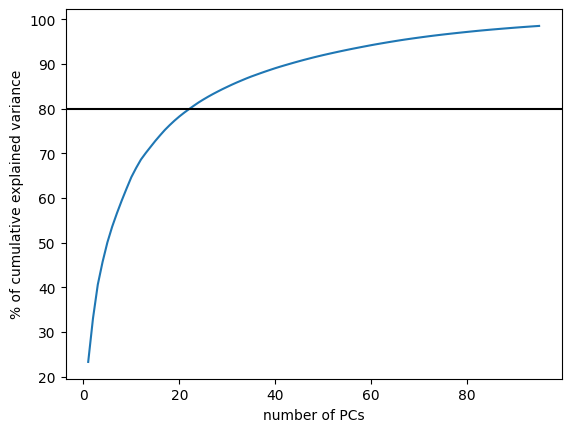

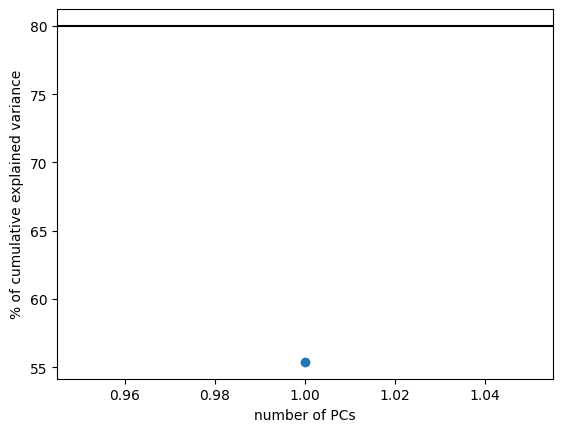

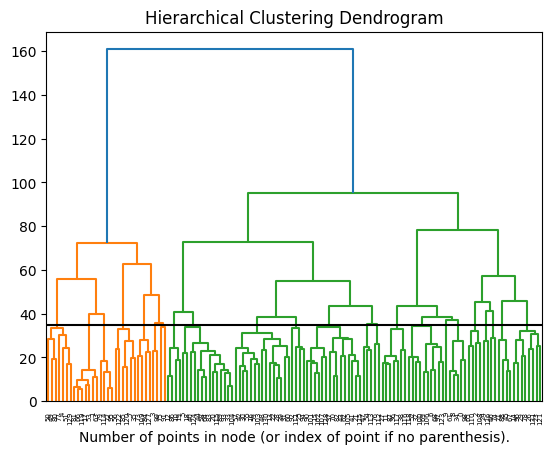

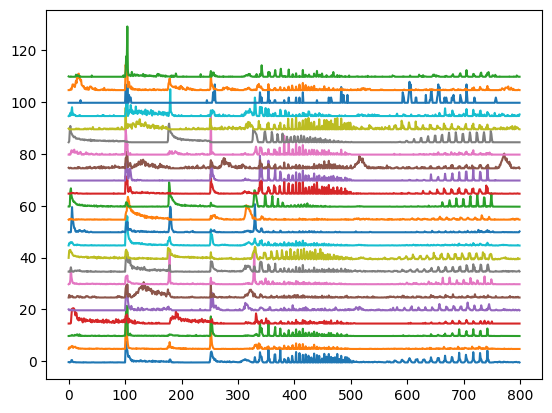

Number of clusters:  23
cluster size : 10


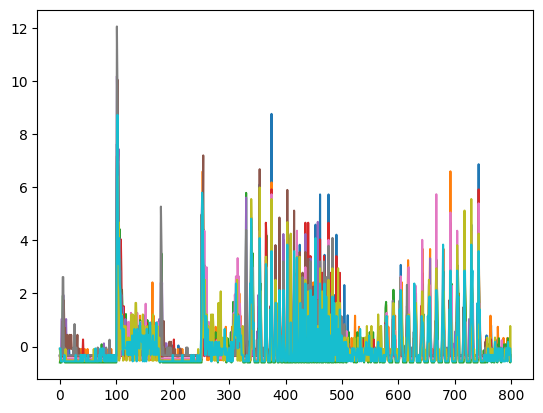

cluster size : 14


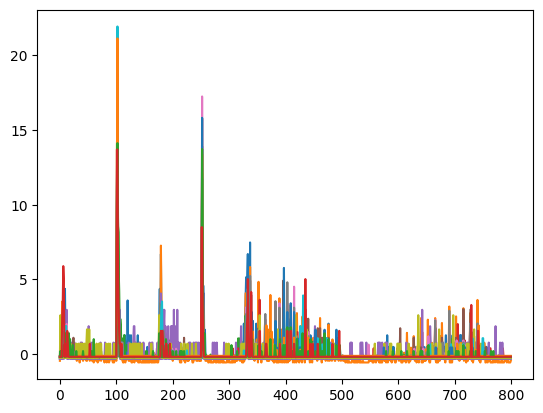

cluster size : 15


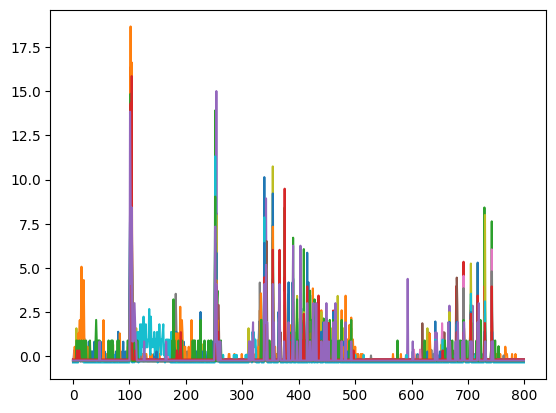

cluster size : 2


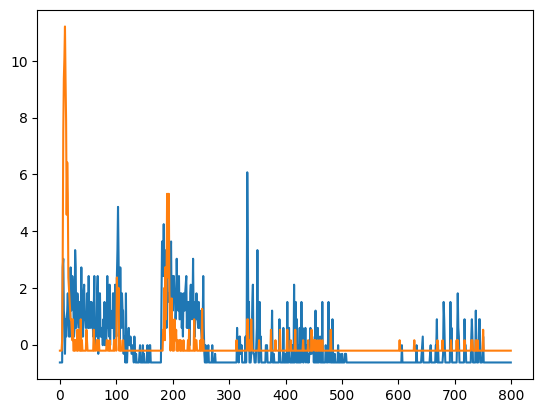

cluster size : 4


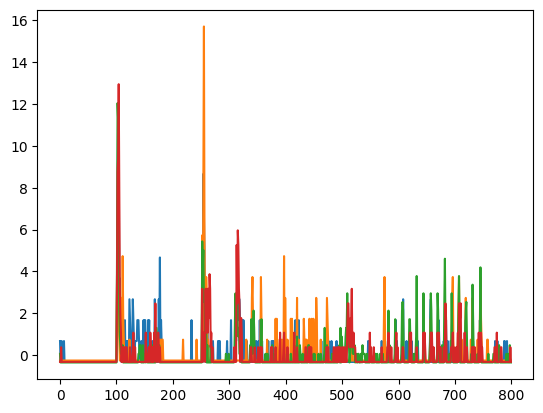

cluster size : 4


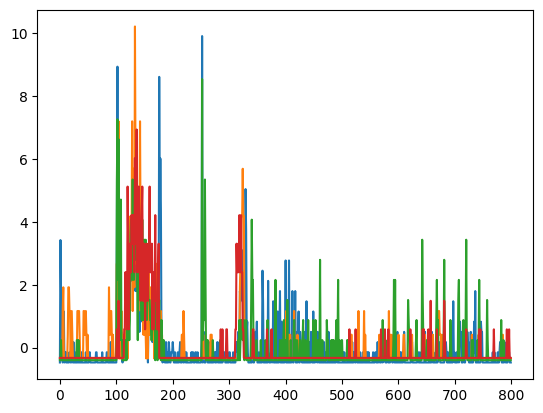

cluster size : 6


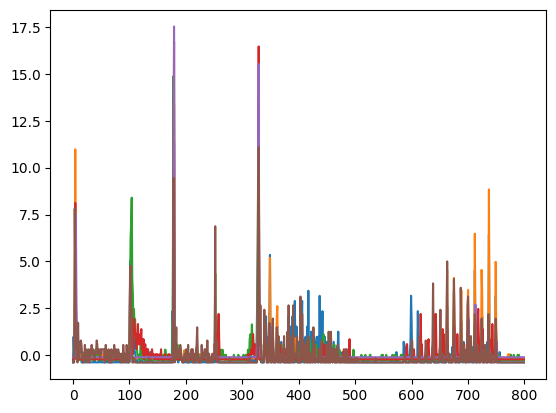

cluster size : 8


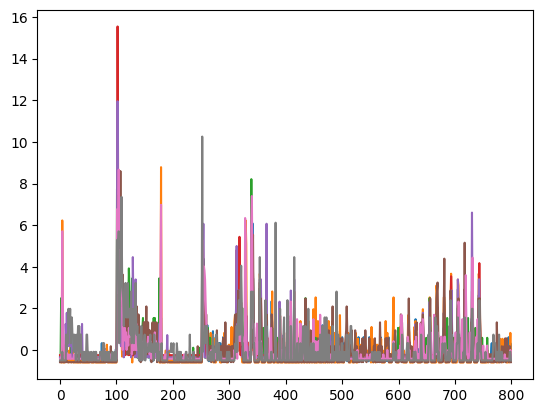

cluster size : 7


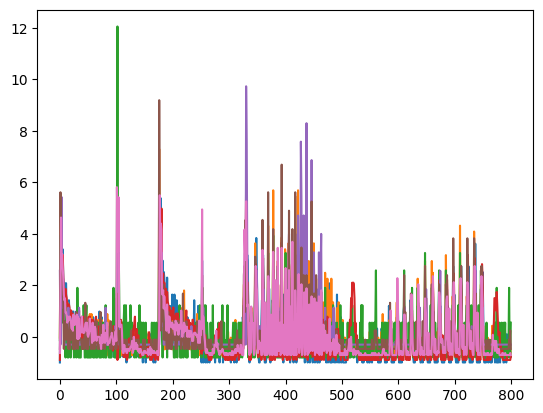

cluster size : 15


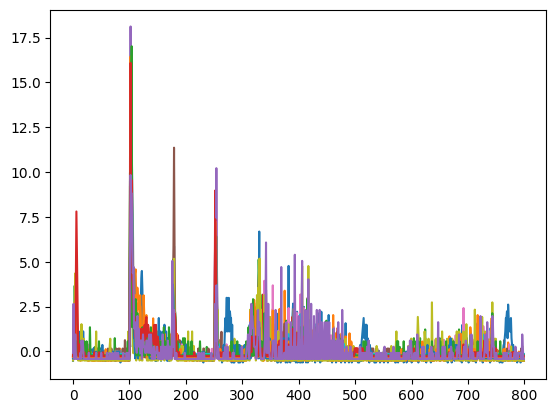

cluster size : 4


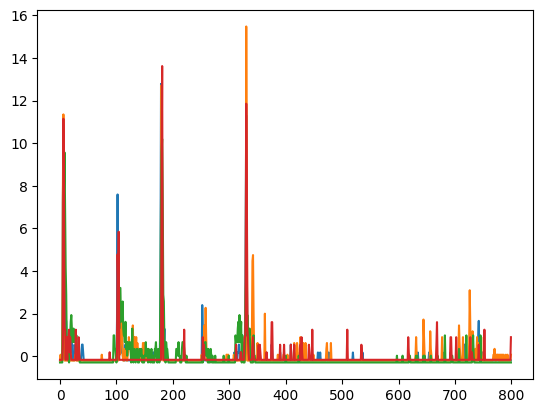

cluster size : 4


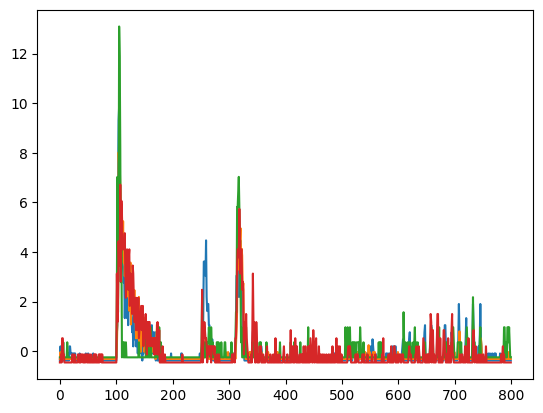

cluster size : 4


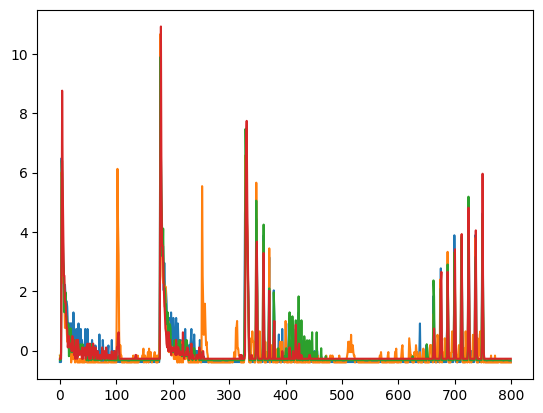

cluster size : 7


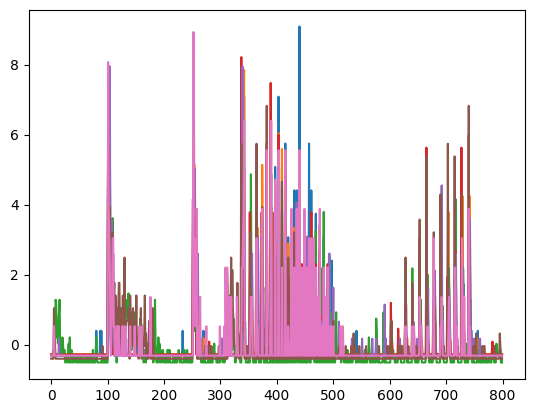

cluster size : 5


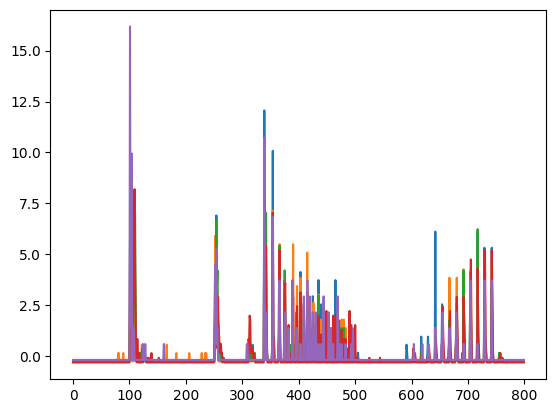

cluster size : 2


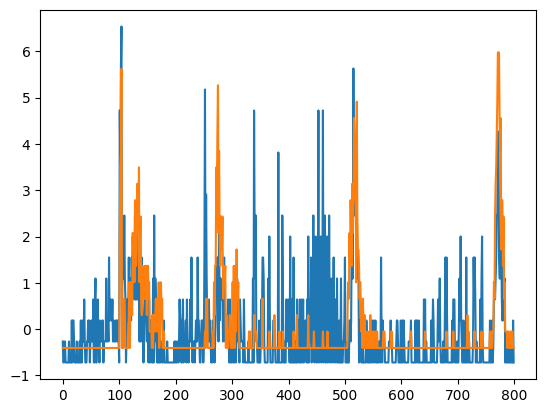

cluster size : 4


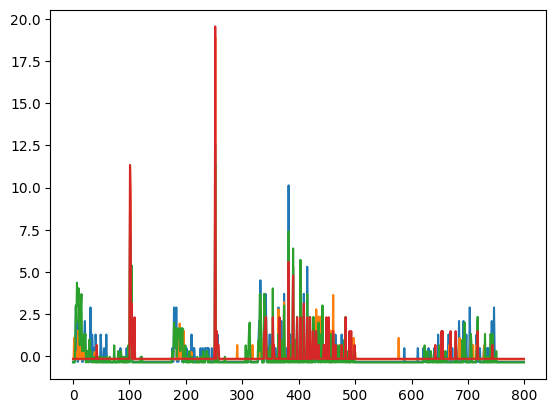

cluster size : 7


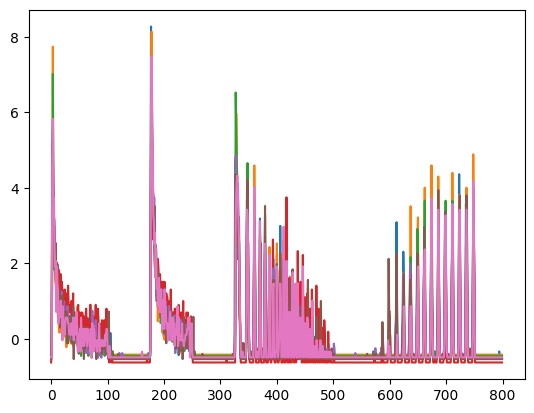

cluster size : 2


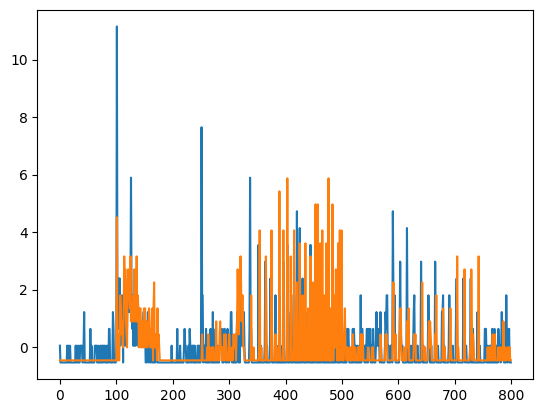

cluster size : 2


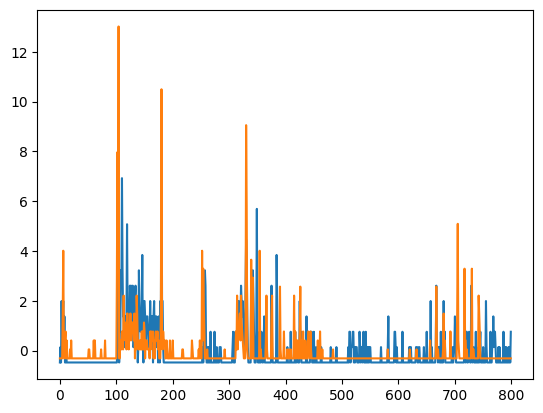

cluster size : 1


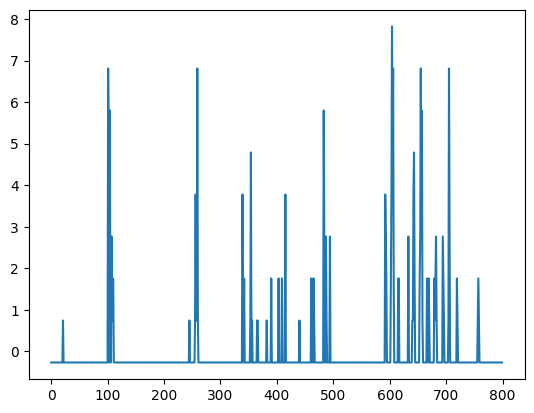

cluster size : 2


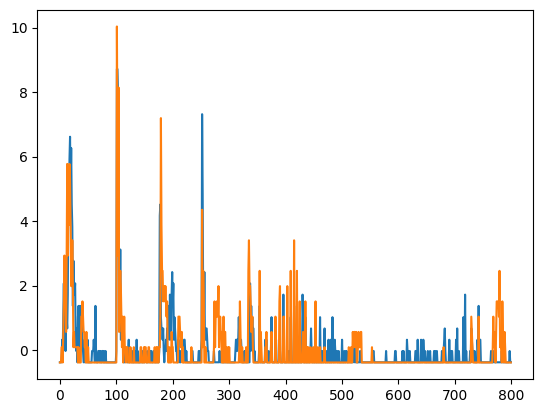

cluster size : 3


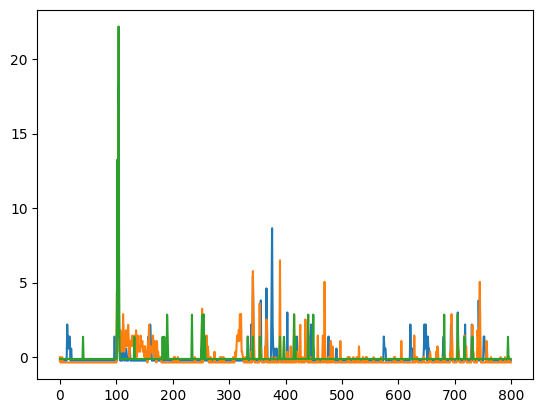

In [49]:


sparse=False
# change dist_thres to adapt the cut of the dendrogram and select the number of clusters
#####################################################################
dist_thres = 35#13
#####################################################################

n_cells = len(selected_cells)
#-----------------------------------
#-----------------------------------
# Get Euler PCA
n_rep = 20 # nb of repeats
nt = 32 # total length
dt = 0.04 # bin size in seconds
time_bins = np.arange(0,nt+dt,dt)

spikes = np.zeros((n_cells, int(nt/dt), n_rep))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    spike_cell = cell_data[cell_id]["spike_trains"]
    for rep in range(n_rep):
        temp=np.histogram(spike_cell[rep], bins=time_bins)
        spikes[cell_index,:,rep] = temp[0]

#-------------------------
# Pre process the PSTH
psth = np.mean(spikes, 2)
psth_z = sc.stats.zscore(psth, 1)

# Select number of PCs to keep so to explain ~80% of the variance
#####################################################################
n_components_psth = 95  #13#16
#####################################################################
if sparse:
    pca_transformer = SparsePCA(n_components_psth, random_state=0).fit(psth_z)
else:
    pca_transformer = PCA(n_components_psth).fit(psth_z)
psth_pca = pca_transformer.transform(psth_z)
# -----------------------------------
# -----------------------------------
# Get checkerboard STA PCA
STA_time_course = np.zeros((n_cells,21))  #21 data points for these STAs
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    TempSTA_cell = sta_results[selected_cells[cell_index]]['center_analyse']['Temporal'][-21:]
    STA_time_course[cell_index] = TempSTA_cell
#---------------------------
# Pre process the STA
sta_tc = sc.stats.zscore(STA_time_course[:,:], 1)
#####################################################################
n_components_sta_tc = 1
#####################################################################
if n_components_sta_tc>0:
    pca_transformer2 = PCA(n_components_sta_tc).fit(sta_tc)
    sta_tc_pca = pca_transformer2.transform(sta_tc)
#-----------------------------------
#-----------------------------------
if not sparse:
    plt.plot(np.arange(n_components_psth)+1, np.cumsum(pca_transformer.explained_variance_ratio_)*100)
    plt.axhline(y=80, color='k')
    plt.xlabel('number of PCs')
    plt.ylabel('% of cumulative explained variance')
    plt.show()

    if n_components_sta_tc>0:
        plt.plot(np.arange(n_components_sta_tc)+1, np.cumsum(pca_transformer2.explained_variance_ratio_)*100,'o-')
        plt.axhline(y=80, color='k')
        plt.xlabel('number of PCs')
        plt.ylabel('% of cumulative explained variance')
        plt.show()
        
        
#-----------------------------------
#-----------------------------------
cluster_dataset = np.zeros((n_cells, n_components_psth+n_components_sta_tc+1))
cluster_dataset[:,:n_components_psth] = psth_pca
if n_components_sta_tc>0:
    cluster_dataset[:,n_components_psth:n_components_psth+n_components_sta_tc] = sta_tc_pca

ell_size=np.zeros(len(selected_cells))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    width,height = [sta_results[selected_cells[cell_index]]['center_analyse']['EllipseCoor'][3],  sta_results[selected_cells[cell_index]]['center_analyse']['EllipseCoor'][4]]
#     width,height = cell_data[cell_id]["ellipseSigmaXY"]
    ell_size[cell_index] = np.abs(np.pi*width*height)
    
ell_size_temp = -np.ones(n_cells)
temp = ell_size[:]-ell_size[:].min()
ell_size_temp[:] = temp/temp.max()
cluster_dataset[:,-1] = ell_size_temp
#-----------------------------------
#-----------------------------------

# perform agglomerative clustering
model = AgglomerativeClustering(distance_threshold=dist_thres, n_clusters=None)
#model = model.fit(psth_pca)
model = model.fit(cluster_dataset)

# plot the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=0)
plt.axhline(dist_thres, color='k')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# plot the cluster centroids
n_clusts = len(np.unique(model.labels_))
plt.figure()
for iclust in range(n_clusts):
    idx_cluster = np.where(model.labels_==iclust)[0]
    plt.plot(np.mean(psth_z[idx_cluster,:], 0) + iclust * 5)
plt.show() 
    
print('Number of clusters: ',len(np.unique(model.labels_)))

# plot the psths of all cells in one cluster
for icluster in range(len(np.unique(model.labels_))):
    # icluster = 0
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(f'cluster size : {len(idx_cluster)}')
    plt.figure()
    plt.plot(psth_z[idx_cluster,:].transpose())
    plt.show()

## Cell 7: Save each cell's cluster number in the chirp response dictionary

In [50]:
# Save the cluster of each cell
for cell_index in range(len(selected_cells)):
    cell_nb = selected_cells[cell_index]
    cell_data[cell_nb]["type"] = model.labels_[cell_index]
for cell in cells:
    if cell not in selected_cells:
        cell_data[cell]["type"] = 'Not assigned'

## Cell 8: Create a summary figure for each cluster type

#### <center><i>REQUIRES CELL 6 RUN </center>

In [51]:
fig_directory = os.path.normpath(os.path.join(output_directory,r'Cell_typing'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

if old:
    vec_path = os.path.join('./types_matching', r"EulerStim180530.vec")
    euler_vec = -np.genfromtxt(vec_path)  
else:    
    vec_path = os.path.join('./types_matching', r"Euler_50Hz_20reps_1024x768pix.vec")
    euler_vec = np.genfromtxt(vec_path) 


for icluster in range(len(np.unique(model.labels_)))[:]:
    idx_cluster = np.where(model.labels_==icluster)[0]
    print('Number of cells in cluster {}: {}'.format(icluster,len(idx_cluster)))

    gs = GridSpec(len(idx_cluster)+2,6)
    
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
    fig=plt.figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
    plt.suptitle("Cell group {}.\n {} cells.".format(icluster, len(idx_cluster)))

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs=np.zeros(21)
    STAcount=0
    waves=np.zeros(101)
    wavecount=0
    ax0= fig.add_subplot(gs[0:2,0:2])
    for index in sorted(idx_cluster):
        cell_nb = selected_cells[index]
        
        #-----------------
        # Plot temp STA
        ax= fig.add_subplot(gs[line,1])
        
#         ax.set_ylim([-4,4])
        ax.axis("off")
        ax.set_aspect(0.175)
        temporal_sta=sta_results[cell_nb]['center_analyse']['Temporal'][-21:]
        ax.step(np.linspace(-21/30,0,21),temporal_sta,'k',lw=3)
#         ax.set_title('Cluster {}'.format(cell_nb))
        ax.axhline(0,color='k',lw=0.5)
        
        STAs+=temporal_sta
        STAcount+=1
        
        #-----------------
        # Plot temp STA avg
        ax= fig.add_subplot(gs[0,2])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-4,4])
        ax.plot(np.linspace(-21/30,0,21),temporal_sta,lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        
         #-----------------
        # plot Chirp
        ax= fig.add_subplot(gs[line,3:])
        
        cell_index=selected_cells.index(cell_nb)
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        
        #-----------------
        # plot Spatial STA
        ax= fig.add_subplot(gs[line,0])
        
        parameters=sta_results[cell_nb]['center_analyse']['EllipseCoor']
        x0=parameters[1]
        y0=parameters[2]
        
        ax = plot_sta(ax, sta_results[cell_nb]['center_analyse']['Spatial'],parameters)
        ax.set_xlim(x0-4,x0+4)
        ax.set_ylim(y0+4,y0-4)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        gaussian = gaussian2D(sta_results[cell_nb]['center_analyse']['Spatial'].shape,*parameters)
        if parameters[0] != 0:
            ax0.contour(np.abs(gaussian),levels = [0.6*np.max(np.abs(gaussian))], colors='k',linestyles = 'solid', alpha = 0.8)

        ax= fig.add_subplot(gs[line,2])
        ax.annotate('Cluster {}'.format(cell_nb), (0,0.5), (0, 0.5), fontsize=15)

        ax.axis('off')
        
        line+=1
    #-----------------
    # avg STA
    STAs=STAs/STAcount
    ax= fig.add_subplot(gs[0,2])
    ax.plot(np.linspace(-21/30,0,21),STAs,'k',lw=2)
#     ax.set_ylim([-4,4])
    ax.set_aspect(0.175)
    ax.axis("off")

    #-----------------
    #size ellipses
    
    ax0.set_title('Ellipses')
#     ax0.set_xlim(4,20)
#     ax0.set_ylim(20,4)
    ax0.set_aspect('equal')
    ax0.set_xticks([])
    ax0.set_yticks([])
        
    #-----------------
    # mean chirp psth
    ax= fig.add_subplot(gs[0,3:])
    ax.set_title('Chirp psth')
    
    ax.plot(np.linspace(0,32,800),np.mean(psth_z[idx_cluster,:], 0),'b')
    ax.axis("off")

    #-----------------
    # plot chirp stim
    ax= fig.add_subplot(gs[1,3:])
    
    ax.plot(np.linspace(0,32,1600),euler_vec[0+151:151+1600,1]*1., color='k')
    ax.set_yticks([])
    ax.set_ylim([-100,350])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    fsave = os.path.join(fig_directory, 'Cluster_{}'.format(icluster))
    fig.savefig(fsave+'.png',format='png',dpi=250)
    plt.close(fig)  

Number of cells in cluster 0: 10
Number of cells in cluster 1: 14
Number of cells in cluster 2: 15
Number of cells in cluster 3: 2
Number of cells in cluster 4: 4
Number of cells in cluster 5: 4
Number of cells in cluster 6: 6
Number of cells in cluster 7: 8
Number of cells in cluster 8: 7
Number of cells in cluster 9: 15
Number of cells in cluster 10: 4
Number of cells in cluster 11: 4
Number of cells in cluster 12: 4
Number of cells in cluster 13: 7
Number of cells in cluster 14: 5
Number of cells in cluster 15: 2
Number of cells in cluster 16: 4
Number of cells in cluster 17: 7
Number of cells in cluster 18: 2
Number of cells in cluster 19: 2
Number of cells in cluster 20: 1
Number of cells in cluster 21: 2
Number of cells in cluster 22: 3


## Cell 9: When satisfied with the clustering, save data

In [52]:
fsave = os.path.join(output_directory, '{}_cell_typing_data'.format(exp) )  
save_obj(cell_data,fsave)

# fsave = os.path.join(output_directory, 'Exp{}_clustermodel'.format(exp) )  
# save_obj([model,psth_z],fsave)

# ----------------------work in progress-----------------------------------

In [ ]:
def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              ##################### changes here
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace

# Matching with Baden et al. clusters

In [ ]:
types_matching_folder= './types_matching'
baden=loadmat(os.path.join( types_matching_folder,'baden_data.mat'))
calcium=loadmat(os.path.join( types_matching_folder,'calcium_conversion.mat'))

#the normalized profile of the chirp stimulus used in Baden et al.  #31988 points
chirp_stim=baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0])

#the triggers used in Baden et al. plus two seconds (to match them with our stimulus)  #31988 points
chirp_stim_time = baden['chirp_stim_time'][0,:] +2

# a 249 points array from 0 to 32 seconds. Times of calcium sampling at 8Hz?
baden_time_original = baden['chirp_time'][0,:]

# a (11210, 1) array. I suppose 11210 were the measurements taken and in this array are the labels of the groups
# in which each measurment was clustered
group_idx = baden['group_idx'] 

# the average calcium traces for each measurement. Each measurement has 249 time points.
psth_euler = baden['chirp_avg']

#here I load from a csv the labels of the Baden types
euler_labels_f = open(os.path.join( types_matching_folder, 'Baden Types'))
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}    #this contains the 32 labels of the euler cell types
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1
#------------------- 

n_baden_types = len(euler_labels)

#our stimulus. Load it and normalize it
vec_path = './types_matching/Euler_50Hz_20reps_1024x768pix.vec'
euler_vec = np.genfromtxt(vec_path)
euler_vec = euler_vec[151:151+1600,1]/max(euler_vec[151:151+1600,1])

#### Repeat this check for the older chirp version!!!!!!

nb_chirp_bins=cell_data[cells[0]]["psth"].size

plt.figure(figsize = (16,4))
time_stim = np.linspace(0,32,1600+1)[:-1]
time = np.linspace(0,32,nb_chirp_bins+1)[:-1]
# Our chirp
plt.plot(time_stim, euler_vec, label='our chirp')
euler_vec.shape
euler_vec[::5].shape,time.shape
# Baden chirp
plt.plot(chirp_stim_time ,chirp_stim+1.5, label = 'Baden chirp')
chirp_stim_time.shape, chirp_stim.shape
plt.legend(frameon=False)

# Comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects ### why 0.1 and not 2 ?
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)


In order to make ours and the baden traces match we have to shift Baden's sampling times of two seconds. But then this will create missing sampling times for Baden and so here we take the last two seconds worth of Baden's sampling times and we stitch them at the beginning of the sampling times sequence

In [ ]:
# the two additional seconds at the end of Baden stim that will be stitched in the beginning
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32 
baden_time = np.append(baden_first,baden_time[:-15])

#we do the same for the calcium traces
Baden_types = []

plt.figure(figsize=(8,16))

for i in np.arange(n_baden_types)+1:
    #here the calcium traces of all the recordings of each type are averaged together
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)  
    #and here they are all put between 0 and 1
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch the last 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plt.plot(baden_time,trace-i)
    plt.text(35,-i,str(i)+'  '+euler_labels[i-1][0])

## Transform the clustering results into calcium traces

In [ ]:
## make it loadable!!

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

In [ ]:
# Generate experiment type traces
Exp_types = []
fig = plt.figure(figsize=(12,24))
fig.add_subplot(1,2,1)
for i in exp_labels:
    #I repeat to my spiking data the treatment I did for the Euler's calcium traces
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plt.plot(time,trace+i)
    plt.title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    # I transform each cluster's mean psth into a calcium trace
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace    #the only difference is that my made-up calcium traces have the dimension of the 
                                #number of bins the PSTHs had while the baden traces have dimension 249
    plt.plot(time,trace+i)
    plt.title('Mean Calcium transform')

# Correlate Groups

In [ ]:
from scipy import interpolate

# Interpolate both calcium traces (Baden and transformed traces) and then calculate them on the same set of times
Baden_common = {}
for i in np.arange(n_baden_types):
    f = interpolate.interp1d(baden_time, Baden_types[i])
    Baden_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

Exp_common={}
for i in exp_labels:
    f = interpolate.interp1d(time, Exp_types_Ca[i])
    Exp_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

#n_matches = 29
corr_table = np.zeros([len(exp_labels),n_baden_types]) 
corr_match = np.zeros([len(exp_labels),n_baden_types])
corr_match_vals = np.zeros([len(exp_labels),n_baden_types])
delta_match = np.zeros([len(exp_labels),n_baden_types+1])

# For each of our generated calcium type we compute the corr coef with each Baden type
for i in exp_labels:
    for j in np.arange(n_baden_types):
        corr_table[i,j] = np.corrcoef(Exp_common[i], Baden_common[j])[0,1]
    # For each calcium type, sort de corr coefs in descending order (max first)
    corr_match[i,:] = np.flip(np.argsort(corr_table[i,:])[-32:]) # sorted indices
    corr_match_vals[i,:] = corr_table[i,:][np.flip([np.argsort(corr_table[i,:])[-32:]])] # sorted corr coef values
    # Select the 10 larger corr coefs and store the difference with the next one
    for j in np.arange(10):
        #each row is one of our clusters and each column is the corr.coeff of that cluster with a Baden one. Decreasing order
        delta_match[i,j] = corr_match_vals[i,j]-corr_match_vals[i,j+1]  

# Manual selection of groups

In [ ]:
my_clusters = range(68)
my_clusters = [0,4,5,8,18,24,32,50,54]

colors = ['orange','r','g','pink','y','gray','k','c','m','darkgray','coral','gold','plum','wheat','navy']
#             0     1   2    3     4    5     6   7   8      9         10      11     12      13     14

baden_cluster=23

for my_clus in my_clusters:

    i=np.where(corr_match[my_clus,:]==baden_cluster)[0][0]
    plt.figure(figsize=(12,2))
    plt.plot(baden_time, Baden_types[baden_cluster],lw=3)
    plt.title('{}, {}'.format(euler_labels[baden_cluster], my_clus))
    
    plt.plot(time, Exp_types_Ca[my_clus],color=colors[my_clus%15])
#     plt.xlabel('match '+colors[n_match%15]+' n ' +str(n_match)+' val '+str(np.round(corr_match_vals[cluster_idx][n_match]*100)) )
#     print('match',str(n_match),' ',j, 'Baden ',i)
#----------------------------------------------------
# manual_selection = corr_match[:,0].astype('int')

# manual_selection=np.zeros()

# manual_selection[5] = corr_match[5,5]
# manual_selection[6] = corr_match[6,14]
# manual_selection[7] = corr_match[7,9]
# manual_selection[9] = corr_match[9,3]
# manual_selection[10] = corr_match[10,21]
# manual_selection[13] = corr_match[13,12]
# manual_selection[14] = corr_match[14,15]
# manual_selection[15] = corr_match[15,15]
# manual_selection[18] = corr_match[18,4]
# manual_selection[19] = corr_match[19,9]
# manual_selection[20] = corr_match[20,4]
# manual_selection[22] = corr_match[22,12]
# manual_selection[25] = corr_match[25,2]
# manual_selection[27] = corr_match[27,10]
# manual_selection[29] = corr_match[29,1]
# manual_selection[32] = corr_match[32,10]

# manual_selection[37] = corr_match[37,25]
# manual_selection[38] = corr_match[38,13]
# manual_selection[41] = corr_match[41,18]
# manual_selection[46] = corr_match[46,1]
# manual_selection[64] = corr_match[64,13]
# manual_selection[66] = corr_match[66,3]
# manual_selection[67] = corr_match[67,21]
# manual_selection[68] = corr_match[68,16]
# manual_selection[69] = corr_match[69,5]
# manual_selection[70] = corr_match[70,1]
# manual_selection[72] = corr_match[72,16]
# manual_selection[73] = corr_match[73,18]

# manual_selection[74] = corr_match[74,3]

# manual_selection[34] = corr_match[34,1]
# manual_selection[62] = corr_match[62,1]
# manual_selection[42] = corr_match[42,1]

# manual_selection[21] =corr_match[21,2]

# manual_selection[48] =corr_match[48,0]

# #----------------------------------------
# man_vals= np.zeros(len(exp_labels))
# for i in exp_labels:
#     if manual_selection[i]!=-1:
#         match = np.where(manual_selection[i]==corr_match[i,:])[0][0]
#         man_vals[i] = corr_match_vals[i,match]

In [ ]:
np.where(corr_match[cluster_idx,:]==23)[0][0]

In [ ]:
#code to replot the cell group ID after the matching

In [ ]:
#code to save the Euler label after the matching

# SAVE DATA

In [ ]:
fsave = os.path.join(output_directory, '{}_cell_typing_data'.format(exp) )  
save_obj(cell_data,fsave)

# fsave = os.path.join(output_directory, 'Exp{}_clustermodel'.format(exp) )  
# save_obj([model,psth_z],fsave)

# fsave = os.path.join(output_directory, 'Exp{}_selected_cells'.format(exp) )  
# save_obj(selected_cells,fsave)

### Old code

In [ ]:
#get cell templates

# template_path = params.phy_directory

# spike_templates = np.load(os.path.join(template_path, 'spike_templates.npy'))   #one template ref per spike
# templates = np.load(os.path.join(template_path,"templates.npy"))
# spike_clusters = np.load(os.path.join(template_path, 'spike_clusters.npy'))

# plt.figure()
# for cell_nb in (good_clusters[:]):   # Is the correct template recovered ?
#     temp_inds=np.unique(spike_templates[spike_clusters==int(cell_nb)])
#     # per each cell temp_inds is a list of the different templates that were assigned to this cell throughout the recording (sometimes it might not be a single one)
    
#     #----------------
    
#     maxt=0
#     for t in temp_inds:
#         for nt in range(templates.shape[2]):
#             if maxt<abs(np.min(templates[t,:,nt])):
#                 maxt=abs(np.min(templates[t,:,nt]))
#                 el_sel=nt
#                 temp_sel=t
#                 # here I select the template index with the biggest spike amplitude. But each template index 
#                 # has several corresponding templates (why?). So even among those, given one template index, I
#                 # chose the one with the biggest spike amplitude

# #     plt.title(cell_nb)
#     plt.plot(templates[temp_sel,:,el_sel])
#     cell_data[cell_nb]["template"] = templates[temp_sel,:,el_sel]